# **Sampling Raster Data using Points or Polygons**

# **Overview**

This tutorial is based on [Sampling Raster Data using Points or Polygons (QGIS3)](https://www.qgistutorials.com/en/docs/3/sampling_raster_data.html).

Many scientific and environmental datasets come as gridded rasters. Elevation data (DEM) is also distributed as raster files. In these raster files, the parameter that is being represented is encoded as the pixel values of the raster. Often, one needs to extract the pixel values at certain locations or aggregate them over some area. This operation - known as Zonal Statistics - can be done using the `rasterstats` library. 

The aim of this tutorial is to extract the temperature at a point layer of all urban areas and calculate the average temperature for a polygon layer of each county in the US from a given raster grid of daily maximum temperature in the continental US by making use of the python libraries. 

Input Layers:

* `us.tmax_nohads_ll_20190501_float.tif`: Raster grid of maximum temprature in the US.
*  `2018_Gaz_ua_national.zip`: A CSV file with point locations representing urban areas in the US.
* `tl_2018_us_county.zip`:  A shapefile of census tracts in California. Download Census Tracts for California file.

Output Layers:

*   `zonal_stats.gpkg` : A GeoPackage containing 2 layers with extracted temperature values.


Data Credit:

*   [US Daily Maximum Temperature Analysis (C)](https://www.cpc.ncep.noaa.gov/products/GIS/GIS_DATA/). Viviane Silva - NOAA Climate Prediction Center. Retrieved 2014-05-27

*   [US Gazetteer files: 2013.](https://www.census.gov/geo/maps-data/data/gazetteer2013.html) United States Census Bureau. Retrieved 2014-05-27.

*   [Texas Water Development Board .](http://www.twdb.texas.gov/) Completed Surveys and Data for Lake Arlington. 2007-12 Shapefiles. Retrieved 2014-11-26.


## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install geopandas
    !pip install rasterio --quiet
    !pip install rasterstats --quiet

     |████████████████████████████████| 1.0 MB 5.2 MB/s 
     |████████████████████████████████| 16.7 MB 32.4 MB/s 
     |████████████████████████████████| 6.3 MB 42.4 MB/s 
     |████████████████████████████████| 19.3 MB 1.1 MB/s 
     |████████████████████████████████| 130 kB 5.1 MB/s 


In [ ]:
import os
import pandas as pd
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import zipfile
import shapely
from shapely.geometry import Point

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

files = [
    '2018_Gaz_ua_national.zip',
    'us.tmax_nohads_ll_20190501_float.tif'
]

for file in files:
  url = '{}/{}'.format(
      'https://github.com/spatialthoughts/python-tutorials/raw/main/data',
      file)
  download(url)



Downloaded data/2018_Gaz_ua_national.zip
Downloaded data/us.tmax_nohads_ll_20190501_float.tif


# Sampling Raster values for a point layer

Reading the required raster file using the `rasterio.open` function.

In [ ]:
raster_path = os.path.join(data_folder,files[1])
max_temp = rasterio.open(raster_path)

Reading the `.txt` file using the `delimiter` as whitespaces and removing any whitespaces present in the Header of the file.

In [ ]:
df  = pd.read_csv(r'/content/data/2018_Gaz_ua_national.zip', compression = 'zip', delimiter = '\t')
df.columns = df.columns.str.replace(' ', '')

Converting the `dataframe` into `geodataframe` and adding the`geometry` of the data.

In [ ]:
urban_places = gpd.GeoDataFrame(df)
urban_places.set_geometry(
    gpd.points_from_xy(urban_places['INTPTLONG'], urban_places['INTPTLAT']),
    inplace=True, crs='EPSG:4326')

Visualizing the ratser and point data. 



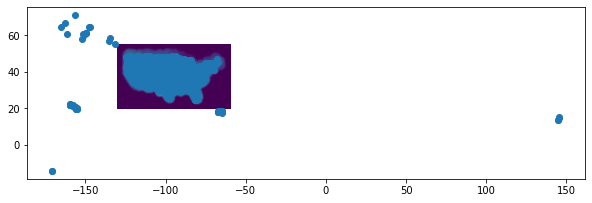

In [ ]:
#This is to show that we have some points that are out of the extend of the raster file.
fig, ax = plt.subplots(figsize = (10,10))
show(max_temp, ax =ax)
urban_places.plot(ax =ax)

Making the `list` of the coordinates of the point and `sampling` the maximum temperature for that point.

The maximum temperature has been stored in a column named `tmax` in `urban_places` geodataframe.

In [ ]:
coord_list = [(x,y) for x,y in zip(urban_places['geometry'].x , urban_places['geometry'].y)]
urban_places['tmax'] = [x for x in max_temp.sample(coord_list)]

Convert `tmax` column type from `list` to `float` ,so that the field is valid for writing with `.to_file`.

In [ ]:
urban_places['tmax'] = urban_places['tmax'].astype('float64')

#Getting the information about the geodataframe
print(urban_places.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3601 entries, 0 to 3600
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   GEOID        3601 non-null   int64   
 1   NAME         3601 non-null   object  
 2   UATYPE       3601 non-null   object  
 3   ALAND        3601 non-null   int64   
 4   AWATER       3601 non-null   int64   
 5   ALAND_SQMI   3601 non-null   float64 
 6   AWATER_SQMI  3601 non-null   float64 
 7   INTPTLAT     3601 non-null   float64 
 8   INTPTLONG    3601 non-null   float64 
 9   geometry     3601 non-null   geometry
 10  tmax         3601 non-null   float64 
dtypes: float64(5), geometry(1), int64(3), object(2)
memory usage: 309.6+ KB
None


The `urban_places` geodataframe contains the locations of the place which were out of the extend of the `max_temp` raster file. So filtering out the rows having `tmax` as `0`.

In [ ]:
urban_places = urban_places[~(urban_places['tmax'] == 0)]
#Getting the information about the geodataframe. Notice that now we have 3535 entries instead of 3601.
print(urban_places.info())

Saving the result to disk as `.gpkg`.

In [ ]:
output_dir = 'output'
output_filename_urban = 'us_tmp_urban_data.gpkg'
output_path = os.path.join(output_dir, output_filename_urban)

urban_places.to_file(driver='GPKG', filename=output_path, layer = 'urban_areas_t',  encoding='utf-8')
print('Successfully written output file at {}'.format(output_path))

Successfully written output file at output/us_tmp_urban_data.gpkg


Let's visualize the results using `tmax` data in a `rainbow` colorRamp.

Text(0.5, 1.0, 'US Maximum Temperature in Celcius')

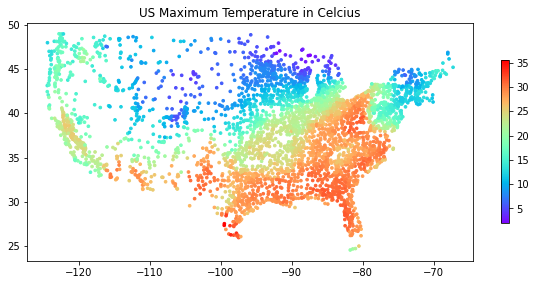

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
urban_places.plot(column = 'tmax', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 7)
ax.set_title('US Maximum Temperature in Celcius')

# Sampling Raster values for a polygon layer

We had already read the raster file. Download the county data from the `US Census Bureau` `TIGER/Line Shapefiles`. 

In [ ]:
#I tried uploading the shapefile but it was greater than 25mb and i couldn't did it so i took help of below code to get the US county file
county_df = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2021/shp/cb_2021_us_county_500k.zip")

Visualizing the ratser and polygon data. 

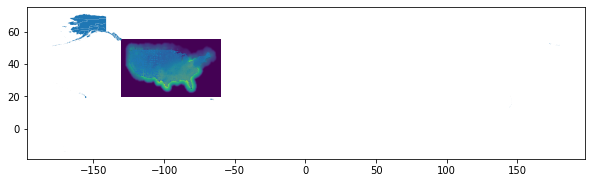

In [ ]:
#This is to show that we have some points that are out of the extend of the raster file.
fig, ax = plt.subplots(figsize = (10,10))
show(max_temp, ax =ax)
county_df.plot(ax =ax)

Getting the `mean` temperature for the `county` of the US by  using the `zonal_stats` function.

By using `all_touched` as `True`, will consider of all the pixels of raster that are in touch with the boundary of the polygon for calculation of statistics.

If `all_touched` is `False` then it will consider only those pixels which are completely inside the boundary of the polygon. 

In [ ]:
mean_temp = zonal_stats(county_df, raster = raster_path, stats = ['mean'], nodata = -999, all_touched = True )

`mean_temp` is a `list` so converting that into a `dataframe` and then concating it with the `county_df` 

In [ ]:
mean_temp_df = pd.DataFrame(mean_temp)
mean_temp_gdf = pd.concat([county_df, mean_temp_df], axis = 1)

#Getting the information about the geodataframe.
print(mean_temp_gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3234 entries, 0 to 3233
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP     3234 non-null   object  
 1   COUNTYFP    3234 non-null   object  
 2   COUNTYNS    3234 non-null   object  
 3   AFFGEOID    3234 non-null   object  
 4   GEOID       3234 non-null   object  
 5   NAME        3234 non-null   object  
 6   NAMELSAD    3234 non-null   object  
 7   STUSPS      3234 non-null   object  
 8   STATE_NAME  3234 non-null   object  
 9   LSAD        3234 non-null   object  
 10  ALAND       3234 non-null   int64   
 11  AWATER      3234 non-null   int64   
 12  geometry    3234 non-null   geometry
 13  mean        3234 non-null   float64 
dtypes: float64(1), geometry(1), int64(2), object(10)
memory usage: 353.8+ KB
None


The `mean_temp_gdf` geodataframe contains the county which were out of the extend of the `max_temp` raster file. So filtering out the rows having `mean` as `0`.

In [ ]:
mean_temp_gdf = mean_temp_gdf[~(mean_temp_gdf['mean'] == 0)]

#Getting the information about the geodataframe. Notice that now we have 3108 entries instead of 3234.
print(mean_temp_gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 3108 entries, 0 to 3233
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP     3108 non-null   object  
 1   COUNTYFP    3108 non-null   object  
 2   COUNTYNS    3108 non-null   object  
 3   AFFGEOID    3108 non-null   object  
 4   GEOID       3108 non-null   object  
 5   NAME        3108 non-null   object  
 6   NAMELSAD    3108 non-null   object  
 7   STUSPS      3108 non-null   object  
 8   STATE_NAME  3108 non-null   object  
 9   LSAD        3108 non-null   object  
 10  ALAND       3108 non-null   int64   
 11  AWATER      3108 non-null   int64   
 12  geometry    3108 non-null   geometry
 13  mean        3108 non-null   float64 
dtypes: float64(1), geometry(1), int64(2), object(10)
memory usage: 364.2+ KB
None


Saving the result to disk as `.gpkg`.

In [ ]:
output_filename_county = 'us_tmp_county_data.gpkg'
output_path = os.path.join(output_dir, output_filename_county)


mean_temp_gdf.to_file(driver='GPKG', filename = output_path, layer = 'mean_temp_gdf',  encoding='utf-8')
print('Successfully written output file at {}'.format(output_path))

Successfully written output file at output/us_tmp_county_data.gpkg


Let's visualize the results using `mean` data in a `rainbow` colorRamp.

Text(0.5, 1.0, 'US Mean Temperature in Celcius')

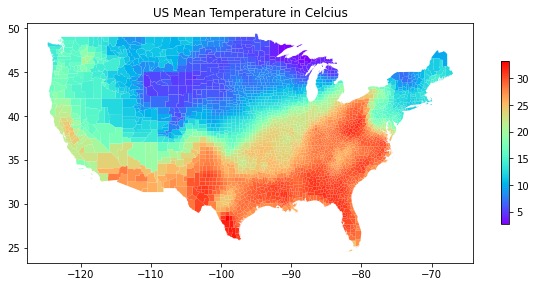

In [ ]:
fig, ax = plt.subplots(figsize = (10,10))
mean_temp_gdf.plot(column = 'mean', ax=ax, cmap = 'rainbow',
            legend = True, legend_kwds={'shrink': 0.3}, 
            markersize = 7)
ax.set_title('US Mean Temperature in Celcius')